In [16]:
#import libraries
import numpy as np
import pandas as pd

import re
import requests
import time
import matplotlib.pyplot as plt

import plotly
from plotly.offline import init_notebook_mode, iplot, plot
%matplotlib inline
init_notebook_mode(connected=True)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import random
random.seed(123)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [17]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [18]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [19]:
df= pd.read_csv('myphdData.csv')
d = df.reset_index().to_dict(orient='list')

In [20]:
df.head()

,Unnamed: 0,ReviewID,ReviewerName,Review,Rating,DateOfReview
0,0,949483680,Zachary T,Id rather have hot fiery Diahrea for a week th...,1.5,2020-01-30T01:32:57.573Z
1,1,883635899,Tina M,I thought movie was horrible.\nThe acting & si...,0.5,2020-01-30T00:19:09.273Z
2,2,973819775,Thomas H,"The plot was good, but nothing we hadnt alread...",1.5,2020-01-29T15:46:09.876Z
3,3,978548560,Kennedy N,It feels like someone pet cemetaried my childh...,0.5,2020-01-29T12:05:05.519Z
4,4,978548342,Bryttany P,"It was alright, great graphics but definitely ...",3.0,2020-01-29T06:19:23.218Z


In [21]:
df['Rating'].max()

5.0

In [22]:
df.shape


(3000, 6)

In [23]:
d['Review']

['Id rather have hot fiery Diahrea for a week than watch this live action fail. \nJust break out your VCR and watch the original.',
 "I thought movie was horrible.\nThe acting & singing is Horrible\nAdded extra stuff that wasn't unnecessary",
 'The plot was good, but nothing we hadnt already seen, and even thought the cgi was impressive, it just didnt bring emotions over like the cartoon.',
 'It feels like someone pet cemetaried my childhood dog. Who thought it was a good idea to zombify cherished memories? This version of Scar and his rendition of Be Prepared broke my heart. Timon and Pumba were pretty funny though.',
 "It was alright, great graphics but definitely lacked the emotion from the original. I wouldn't consider this a kids movie anymore, the fights were a bit more intense that my Toddler was scared some. They took out some of the best songs too which was a bummer. Overall, Could've been better:/",
 "Its ok but it didn't really do anything new.",
 "Horrible. Many filler scen

# Now derive a new columns for sentiment analysis on the movie.

In [34]:
df['sentiment'] = df.Rating.apply(lambda x:1 if x<=3 else 0)

In [35]:
df.drop('Rating',axis=1,inplace= True)
df.head()

,Unnamed: 0,ReviewID,ReviewerName,Review,DateOfReview,sentiment
0,0,949483680,Zachary T,Id rather have hot fiery Diahrea for a week th...,2020-01-30T01:32:57.573Z,1
1,1,883635899,Tina M,I thought movie was horrible.\nThe acting & si...,2020-01-30T00:19:09.273Z,1
2,2,973819775,Thomas H,"The plot was good, but nothing we hadnt alread...",2020-01-29T15:46:09.876Z,1
3,3,978548560,Kennedy N,It feels like someone pet cemetaried my childh...,2020-01-29T12:05:05.519Z,1
4,4,978548342,Bryttany P,"It was alright, great graphics but definitely ...",2020-01-29T06:19:23.218Z,1


In [ ]:
df.dtypes

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x= 'sentiment', data=df)
plt.show()

print(df.sentiment.value_counts())
print(" The movie has higher number of good reviews(0 indicates positive) than bad. Must be a good one")
count_yes = len(df[df.sentiment == 1])
count_no = len(df[df.sentiment != 1])

In [ ]:
#Plot showing the no of rows with '0' and '1' in the 'Sentiment' column
plt.rcParams.update({'font.size': 15})
df['sentiment'].value_counts()[:].plot(kind ='bar',title = 'Sentiment column - Count of different classes',figsize=(3,4))
warnings.filterwarnings('ignore')

# We will use the dictionary going forward

In [36]:
d['Review'] = [text.strip().lower() for text in d['Review']]


d.keys()               

dict_keys(['index', 'Unnamed: 0', 'ReviewID', 'ReviewerName', 'Review', 'Rating', 'DateOfReview', 'clean_text_stemmed', 'clean_text_lemmatized', 'text_stemmed', 'text_lemmatized'])

In [37]:
#d['Review']
#len(df['Review'])

# Idea is to remove the don't to do not. 

In [38]:
contractions = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}   

In [39]:
def expand_contractions(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    return text



In [40]:
d['Review'] = [expand_contractions(re.sub('’', "'", text)) for text in d['Review']]

# Trying to get the word count in unnamed key (d is dictionary here) to check after precessing the not of reduced or not.

In [41]:
d['Unnamed: 0'] =[ len(str(x).split()) for x in d['Review'] ]
#d['Unnamed: 0']
d['Review'] 

['id rather have hot fiery diahrea for a week than watch this live action fail. \njust break out your vcr and watch the original.',
 'i thought movie was horrible.\nthe acting & singing is horrible\nadded extra stuff that was not unnecessary',
 'the plot was good, but nothing we hadnt already seen, and even thought the cgi was impressive, it just didnt bring emotions over like the cartoon.',
 'it feels like someone pet cemetaried my childhood dog. who thought it was a good idea to zombify cherished memories? this version of scar and his rendition of be prepared broke my heart. timon and pumba were pretty funny though.',
 'it was alright, great graphics but definitely lacked the emotion from the original. i would not consider this a kids movie anymore, the fights were a bit more intense that my toddler was scared some. they took out some of the best songs too which was a bummer. overall, could have been better:/',
 'its ok but it did not really do anything new.',
 'horrible. many filler

In [42]:
#d['Review']

In [43]:
import emoji

def text_cleaning_with_emoji(text):

    text=emoji.demojize(text)
    #cleaned_text = emoji_pattern.sub(r' ', text)
    #Replace non ascii / not word and newline
    cleaned_text = re.sub('\\W|\n',' ',text)
     
    #Remove html markup
    cleaned_text = re.sub("<.*?>", ' ', cleaned_text)

    #Remove extra spaces and under score from the text
    cleaned_text = re.sub("(\s+)|_",' ',cleaned_text)
    return cleaned_text


In [44]:
def text_cleaning(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    cleaned_text = emoji_pattern.sub(r' ', text)
    #Replace non ascii / not word and newline
    cleaned_text = re.sub('\\W|\n',' ',cleaned_text)
     
    #Remove html markup
    cleaned_text = re.sub("<.*?>", ' ', cleaned_text)

    #Remove extra spaces from the text
    cleaned_text = re.sub("(\s+)",' ',cleaned_text)
    return cleaned_text

In [45]:
#d['Review'] = [text_cleaning(t) for t in d['Review']]

In [46]:
d['Review']

['id rather have hot fiery diahrea for a week than watch this live action fail. \njust break out your vcr and watch the original.',
 'i thought movie was horrible.\nthe acting & singing is horrible\nadded extra stuff that was not unnecessary',
 'the plot was good, but nothing we hadnt already seen, and even thought the cgi was impressive, it just didnt bring emotions over like the cartoon.',
 'it feels like someone pet cemetaried my childhood dog. who thought it was a good idea to zombify cherished memories? this version of scar and his rendition of be prepared broke my heart. timon and pumba were pretty funny though.',
 'it was alright, great graphics but definitely lacked the emotion from the original. i would not consider this a kids movie anymore, the fights were a bit more intense that my toddler was scared some. they took out some of the best songs too which was a bummer. overall, could have been better:/',
 'its ok but it did not really do anything new.',
 'horrible. many filler

In [47]:
def scrub_words(text):
    #Replace emoji characters in text
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    cleaned_text = emoji_pattern.sub(r' ', text)
    
    #Replace non ascii / not words and digits
    text = re.sub("(\\W|\\d)",' ',text)
    
    #Replace new line characters and following text untill space
    text = re.sub('\n(\w*?)[\s]', '', text)
    
    #Remove html markup
    text = re.sub("<.*?>", ' ', text)
    
    #Remove extra spaces from the text
    text = re.sub("\s+", ' ', text)
    return text

In [48]:
d['Review'] = [scrub_words(t) for t in d['Review']]

In [49]:
d['Review'] = [scrub_words(t) for t in d['Review']]

In [50]:
d['Review'] = [text_cleaning_with_emoji(t) for t in d['Review']]
d['Review']

['id rather have hot fiery diahrea for a week than watch this live action fail just break out your vcr and watch the original ',
 'i thought movie was horrible the acting singing is horrible added extra stuff that was not unnecessary',
 'the plot was good but nothing we hadnt already seen and even thought the cgi was impressive it just didnt bring emotions over like the cartoon ',
 'it feels like someone pet cemetaried my childhood dog who thought it was a good idea to zombify cherished memories this version of scar and his rendition of be prepared broke my heart timon and pumba were pretty funny though ',
 'it was alright great graphics but definitely lacked the emotion from the original i would not consider this a kids movie anymore the fights were a bit more intense that my toddler was scared some they took out some of the best songs too which was a bummer overall could have been better ',
 'its ok but it did not really do anything new ',
 'horrible many filler scenes or extended sc

In [51]:
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #https://docs.python.org/2/library/unicodedata.html
    return text

In [52]:
d['Review'] = [remove_accented_chars(text) for text in d['Review']]
d['Review']

['id rather have hot fiery diahrea for a week than watch this live action fail just break out your vcr and watch the original ',
 'i thought movie was horrible the acting singing is horrible added extra stuff that was not unnecessary',
 'the plot was good but nothing we hadnt already seen and even thought the cgi was impressive it just didnt bring emotions over like the cartoon ',
 'it feels like someone pet cemetaried my childhood dog who thought it was a good idea to zombify cherished memories this version of scar and his rendition of be prepared broke my heart timon and pumba were pretty funny though ',
 'it was alright great graphics but definitely lacked the emotion from the original i would not consider this a kids movie anymore the fights were a bit more intense that my toddler was scared some they took out some of the best songs too which was a bummer overall could have been better ',
 'its ok but it did not really do anything new ',
 'horrible many filler scenes or extended sc

In [53]:
#TBD engTexts[3] = expandContractions(engTexts[3]) check expandContractions is in which library


In [54]:
#! pip install py-translate

In [55]:
#! pip install googletrans

# Idea is to translate the reviews into english instead of removing it. It's not a good idea to do that. instead read more utf-8 reviews.

In [56]:
from googletrans import Translator

translator = Translator()
tr_text = translator.translate( d['Review'][15], src='spanish', dest='en') 
tr_text.text

'well just I thought I miss that adapted more to the old version'

In [57]:
d['Review'][15] = tr_text.text
d['Review'][15]

'well just I thought I miss that adapted more to the old version'

In [58]:
d['Review'][106]

'para mi me conmovio mucho verlo otra vez y no le veo nada malo a la pelicula solo que es muy oscura y cambiaron cosas importantes del original pero aun asi es hermosa y me hizo llorar una vez mas '

In [59]:

#data = ['para mi me', 'conmovio mucho verlo']

translated = translator.translate(d['Review'][106], src='spanish', dest='en')
translated.text

'I was very moved to see me again and I do not see anything wrong with the only movie that is very dark and important things changed the original but still beautiful and made me mourn once more'

In [60]:
d['Review'][106] = translated.text
d['Review'][106]

'I was very moved to see me again and I do not see anything wrong with the only movie that is very dark and important things changed the original but still beautiful and made me mourn once more'

In [61]:
translate = translator.translate(d['Review'][108], src='portuguese', dest='en')
d['Review'][108]  = translate.text
d['Review'][108]

'pretty good however the animals did not have reactions'

In [62]:
translated = translator.translate(d['Review'][86], src='spanish', dest='en')
d['Review'][86] =translated.text
d['Review'][86]

'It is visually beautiful but does not offer anything new is exactly like the animated'

In [63]:
d['Review'] = [re.sub(' s ',' ',t) for t in  d['Review']]

# Try to translate in a better way. Nore there could be many different language to convert

In [64]:
stopword = spacy.lang.en.stop_words.STOP_WORDS


In [65]:
stopword.update(['s', 't', 'movie', 'eyes', 'face', 'original', 'version','cgi' , 'story', 'time', 'new', 'voice','king', 'lion','remake', 'felt','feel','nt','way','old','feel','songs','m','visuals','visually','didn','film','story','family','know', 'movies','people','wasn' , 'see','think', 've','thing', 'cg', 'help','need', 'job', 'machine', 'prepare', 'come', 'animation', 'see', 'character', 'age', 'kid', 'exactly', 'evntually', 'stay', 'music', 'scene', 'material', 'wife', 'care'])
stopword

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'age',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'animation',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'care',
 'cg',
 'cgi',
 'character',
 'come',
 'could',
 'did',
 'didn',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'evntually',
 'exactly',
 'except',
 'eyes',
 '

In [66]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [67]:

def tokenize_and_stem(doc, remove_stopwords = True):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    if remove_stopwords:
        tokens = [word.text for word in doc if not word.is_stop]
    else:
        tokens = [word.text for word in doc]

    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)

    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_and_lemmatize(doc, remove_stopwords = True):
    
    if remove_stopwords:
        tokens = [word for word in doc if not word.is_stop]
    else:
        tokens = [word for word in doc]
        
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token.text):
            filtered_tokens.append(token)
            
    lemma = [t.lemma_ for t in filtered_tokens]
    return lemma


def tokenize_only(doc, remove_stopwords = True):
    
    if remove_stopwords:
        tokens = [word.text for word in doc if not word.is_stop]
    else:
        tokens = [word.text for word in doc]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [68]:

d['clean_text_stemmed'] = []
d['clean_text_lemmatized'] = []
d['text_stemmed'] = []
d['text_lemmatized'] = []

vocab_stemmed = []
allvocab_stemmed =[]

vocab_tokenized = []
allvocab_tokenized = []

vocab_lemmatized = []
allvocab_lemmatized = []


for idx,text in enumerate(d['Review']):

    doc = nlp(text)
    #print(f"processing {idx} document")
    words_stemmed = tokenize_and_stem(doc)
    vocab_stemmed.extend(words_stemmed)
    d['clean_text_stemmed'].append(words_stemmed)
        
    words_lemmatized = tokenize_and_lemmatize(doc)
    vocab_lemmatized.extend(words_lemmatized)
    d['clean_text_lemmatized'].append(words_lemmatized)
    
       
    allwords_stemmed = tokenize_and_stem(doc, False)
    allvocab_stemmed.extend(allwords_stemmed)
    d['text_stemmed'].append(allwords_stemmed)
    
    allwords_lemmatized = tokenize_and_lemmatize(doc, False)
    allvocab_lemmatized.extend(allwords_lemmatized)
    d['text_lemmatized'].append(allwords_lemmatized)
    
    allwords_tokenized = tokenize_only(doc,False)
    allvocab_tokenized.extend(allwords_tokenized)
    
    words_tokenized = tokenize_only(doc)
    vocab_tokenized.extend(words_tokenized)

In [89]:
words_lemmatized

['thrill',
 'original',
 'visually',
 'beautiful',
 'perfect',
 'flawless',
 'lion',
 'king',
 'film',
 'stylish',
 'direction',
 'jon',
 'favreau',
 'screenplay',
 'jeff',
 'nathanson',
 'adapt',
 'original',
 'talented',
 'voice',
 'cast',
 'soundtrack',
 'hans',
 'zimmer',
 'incredible',
 'beautiful',
 'cinematography',
 'caleb',
 'deschanel',
 'opinion',
 'good',
 'movie',
 'avenger',
 'endgame',
 'toy',
 'story',
 'place',
 'spider',
 'man',
 'far',
 'home',
 'disney',
 'hit',
 'remake',
 'good']

In [69]:
pd.DataFrame(d).head(9)+*--*

,index,Unnamed: 0,ReviewID,ReviewerName,Review,Rating,DateOfReview,clean_text_stemmed,clean_text_lemmatized,text_stemmed,text_lemmatized
0,0,24,949483680,Zachary T,id rather have hot fiery diahrea for a week th...,1.5,2020-01-30T01:32:57.573Z,"[d, hot, fieri, diahrea, week, watch, live, ac...","[would, hot, fiery, diahrea, week, watch, live...","[i, d, rather, have, hot, fieri, diahrea, for,...","[-PRON-, would, rather, have, hot, fiery, diah..."
1,1,18,883635899,Tina M,i thought movie was horrible the acting singin...,0.5,2020-01-30T00:19:09.273Z,"[thought, movi, horribl, act, sing, horribl, a...","[think, movie, horrible, acting, singing, horr...","[i, thought, movi, was, horribl, the, act, sin...","[i, think, movie, be, horrible, the, acting, s..."
2,2,26,973819775,Thomas H,the plot was good but nothing we hadnt already...,1.5,2020-01-29T15:46:09.876Z,"[plot, good, nt, seen, thought, cgi, impress, ...","[plot, good, not, see, think, cgi, impressive,...","[the, plot, was, good, but, noth, we, had, nt,...","[the, plot, be, good, but, nothing, -PRON-, ha..."
3,3,40,978548560,Kennedy N,it feels like someone pet cemetaried my childh...,0.5,2020-01-29T12:05:05.519Z,"[feel, like, pet, cemetari, childhood, dog, th...","[feel, like, pet, cemetarie, childhood, dog, t...","[it, feel, like, someon, pet, cemetari, my, ch...","[-PRON-, feel, like, someone, pet, cemetarie, ..."
4,4,53,978548342,Bryttany P,it was alright great graphics but definitely l...,3.0,2020-01-29T06:19:23.218Z,"[alright, great, graphic, definit, lack, emot,...","[alright, great, graphic, definitely, lack, em...","[it, was, alright, great, graphic, but, defini...","[-PRON-, be, alright, great, graphic, but, def..."
5,5,10,856931330,Jesse C,its ok but it did not really do anything new,2.5,2020-01-29T05:47:41.997Z,"[ok, new]","[ok, new]","[it, ok, but, it, did, not, realli, do, anyth,...","[-PRON-, ok, but, -PRON-, do, not, really, do,..."
6,6,114,931683811,Zachary G,horrible many filler scenes or extended scenes...,1.5,2020-01-29T05:05:07.373Z,"[horribl, filler, scene, extend, scene, hour, ...","[horrible, filler, scene, extend, scene, hour,...","[horribl, mani, filler, scene, or, extend, sce...","[horrible, many, filler, scene, or, extend, sc..."
7,7,35,978548087,Ellie C,i have been watching the original lion king ov...,0.5,2020-01-29T02:19:52.970Z,"[watch, origin, lion, king, origin, way, bette...","[watch, original, lion, king, original, way, w...","[i, have, been, watch, the, origin, lion, king...","[i, have, be, watch, the, original, lion, king..."
8,8,28,978494830,Trent M,the lion king live action is the best you can ...,4.0,2020-01-27T05:35:13.601Z,"[lion, king, live, action, best, expect, class...","[lion, king, live, action, good, expect, class...","[the, lion, king, live, action, is, the, best,...","[the, lion, king, live, action, be, the, good,..."


In [70]:
all_vocab_frame = pd.DataFrame({'words': allvocab_tokenized}, index = allvocab_lemmatized)
print ('there are ' + str(all_vocab_frame.shape[0]) + ' items in all_vocab_frame')

vocab_frame = pd.DataFrame({'words': vocab_tokenized}, index = vocab_lemmatized)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 96074 items in all_vocab_frame
there are 42666 items in vocab_frame


In [71]:
vocab_frame.head(5)

,words
would,d
hot,hot
fiery,fiery
diahrea,diahrea
week,week


In [72]:
d["Review"][1:3]

['i thought movie was horrible the acting singing is horrible added extra stuff that was not unnecessary',
 'the plot was good but nothing we hadnt already seen and even thought the cgi was impressive it just didnt bring emotions over like the cartoon ']

In [73]:
values, counts = np.unique(vocab_frame, return_counts=True)
all_word_values, all_word_counts = np.unique(all_vocab_frame,  return_counts= True)

In [74]:
values

array(['ability', 'abit', 'able', ..., 'zombify', 'zoo', 'zoological'],
      dtype=object)

In [75]:
counts

array([ 5,  1, 28, ...,  1,  2,  1], dtype=int64)

# Sort the counts so that highest no of occurences of a value's index is on the top.

In [76]:
sorted_indices = np.argsort(-counts)
print(sorted_indices)


[3175 3419 2797 ... 2431 2750 5555]


In [77]:
all_sorted_indices = np.argsort(-all_word_counts)
print(all_sorted_indices)

[5173 2690  203 ... 3700 3670 5820]


In [78]:
import numpy as np
x = np.array([3, 2, 5])
np.argsort(x)


array([1, 0, 2], dtype=int64)

In [79]:
np.argsort(-x)

array([2, 0, 1], dtype=int64)

In [80]:
values = values[sorted_indices]
counts = counts[sorted_indices]

all_values = all_word_values[all_sorted_indices]
all_counts = all_word_counts[all_sorted_indices]

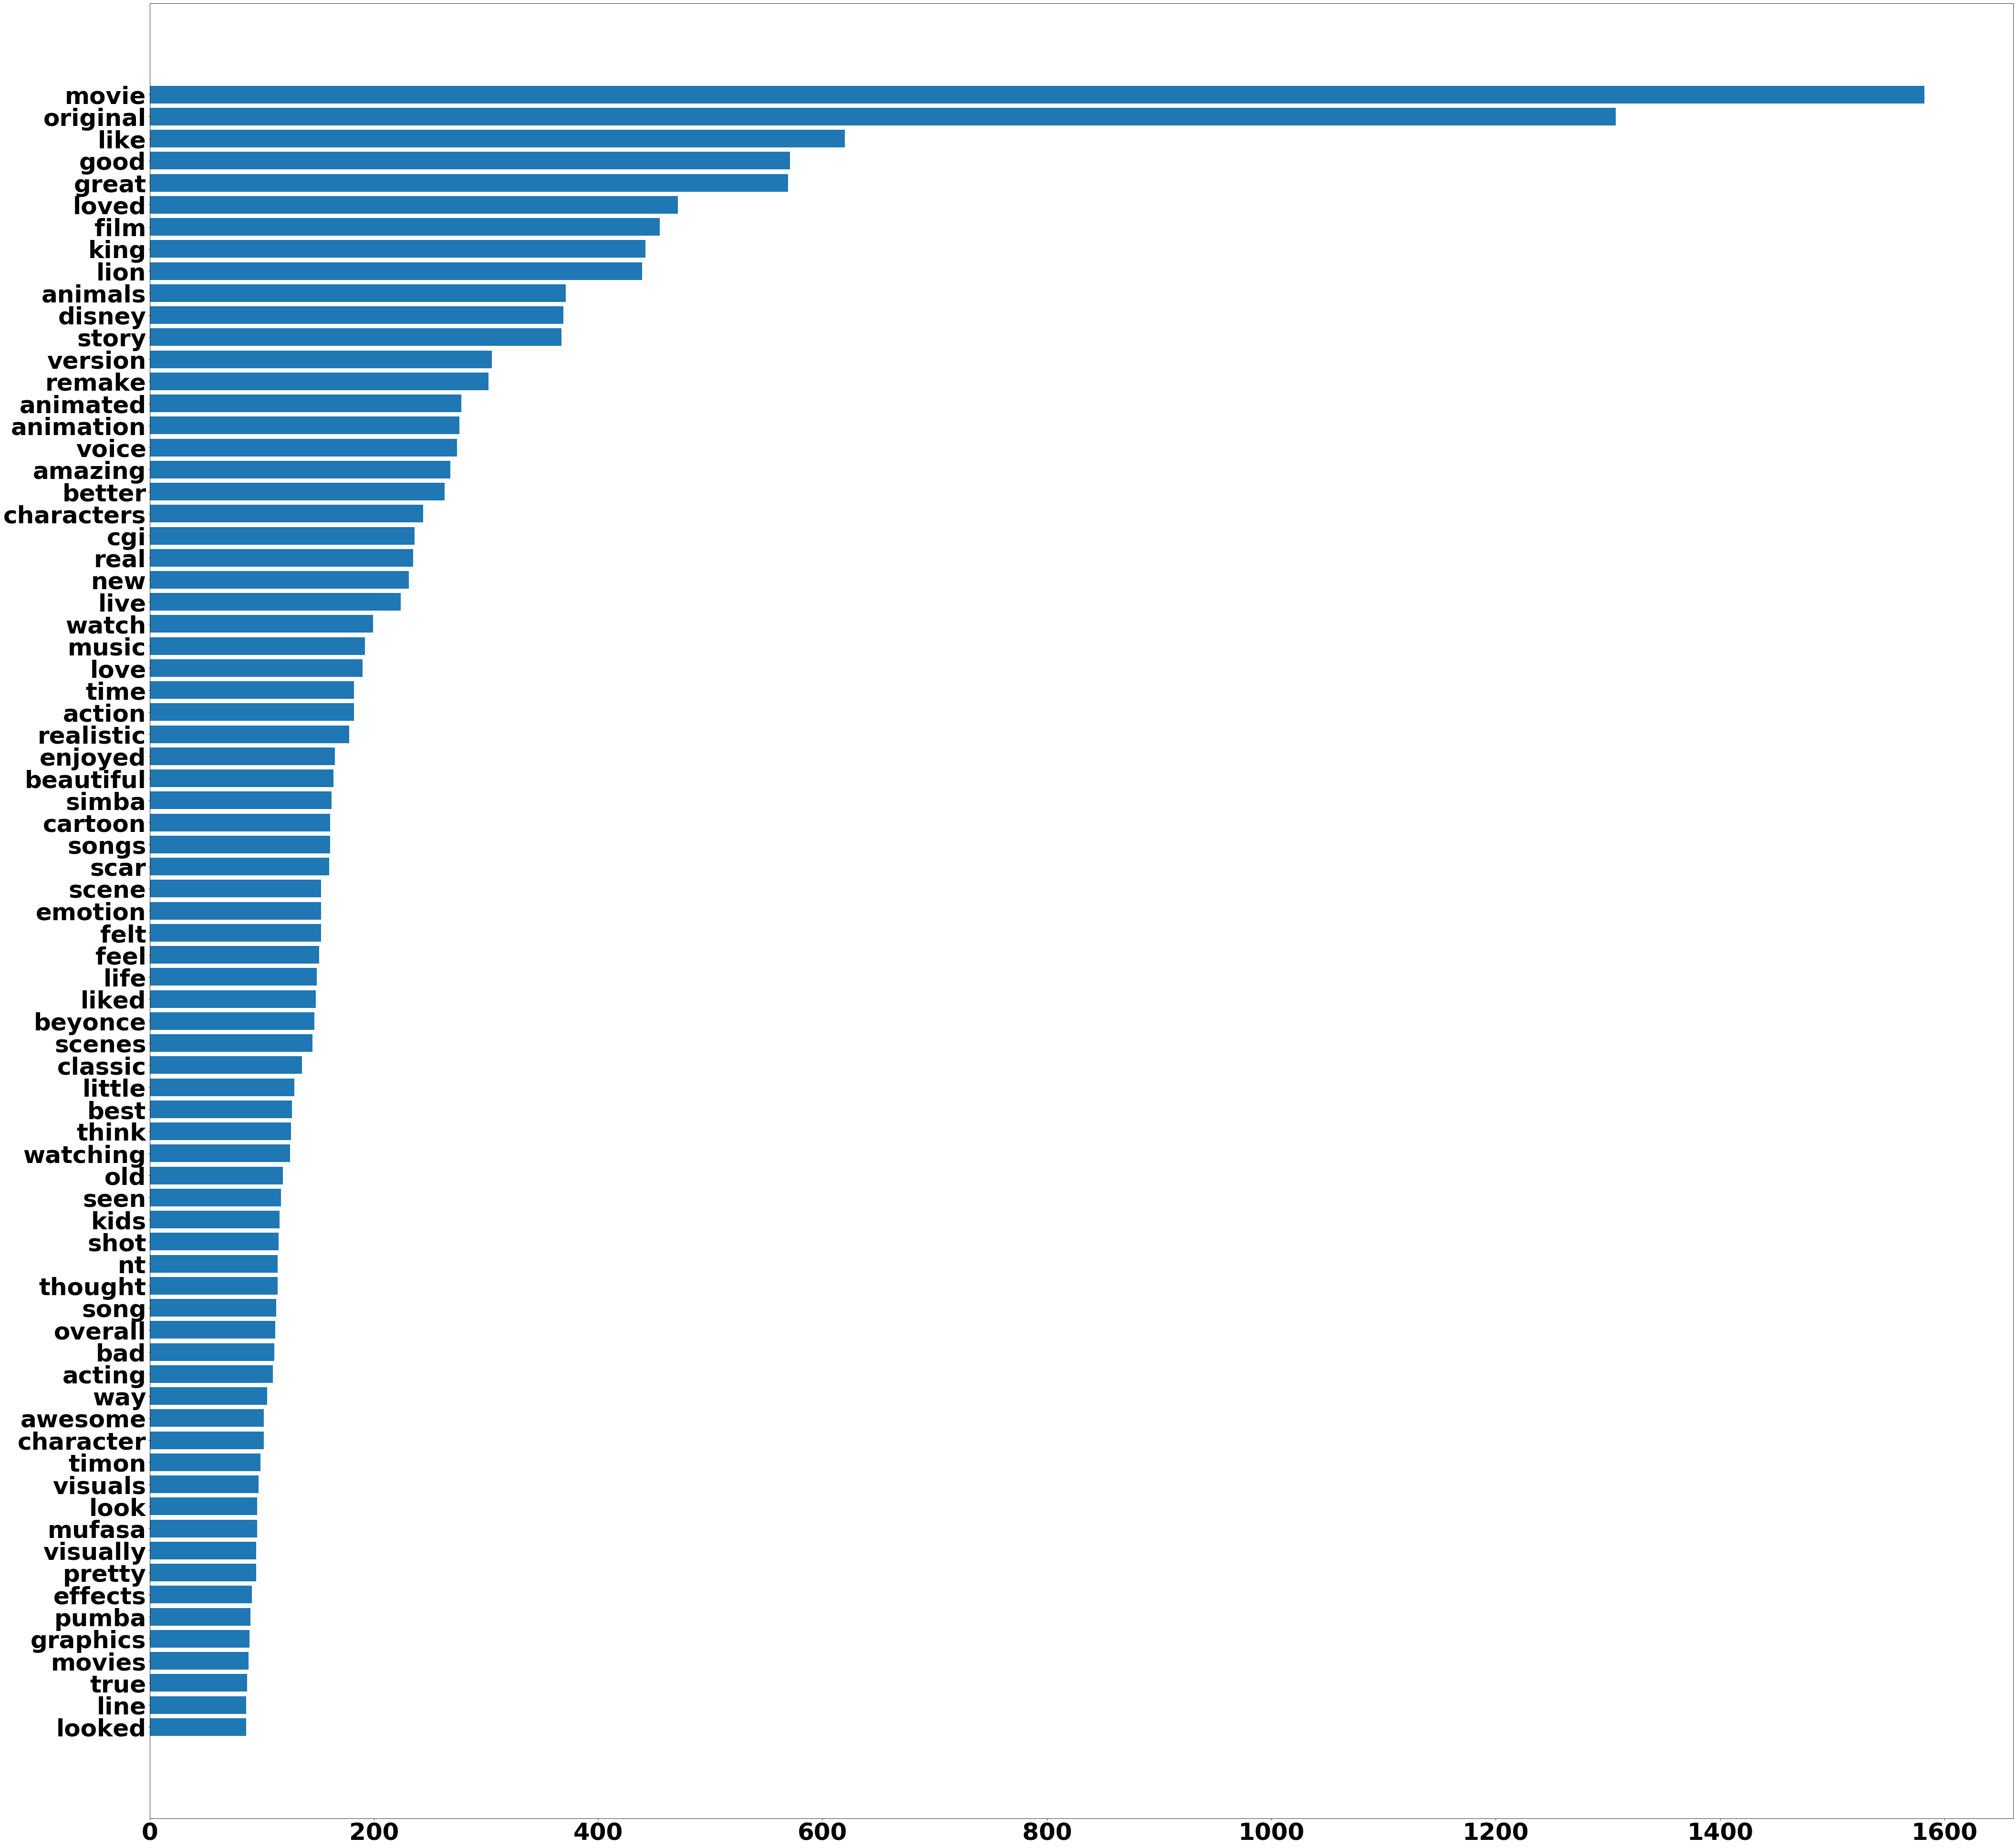

In [81]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 50}

plt.rc('font', **font)
fig = plt.figure(figsize=(70,70))
plt.barh(values[:75], counts[:75])
plt.gca().invert_yaxis()
plt.show()

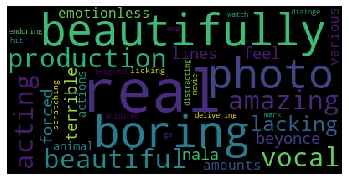

In [56]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(d['Review'][16])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

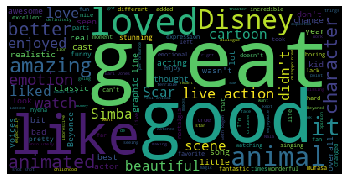

In [57]:
all_words = " ".join(review for review in df.Review)

from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stopword).generate(all_words)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [58]:
d['clean_text_lemmatized']

[['would',
  'hot',
  'fiery',
  'diahrea',
  'week',
  'watch',
  'live',
  'action',
  'fail',
  'break',
  'vcr',
  'watch'],
 ['think',
  'horrible',
  'acting',
  'singing',
  'horrible',
  'add',
  'extra',
  'stuff',
  'unnecessary'],
 ['plot',
  'good',
  'not',
  'see',
  'think',
  'impressive',
  'not',
  'bring',
  'emotion',
  'like',
  'cartoon'],
 ['feel',
  'like',
  'pet',
  'cemetarie',
  'childhood',
  'dog',
  'think',
  'good',
  'idea',
  'zombify',
  'cherished',
  'memory',
  'scar',
  'rendition',
  'prepare',
  'break',
  'heart',
  'timon',
  'pumba',
  'pretty',
  'funny'],
 ['alright',
  'great',
  'graphic',
  'definitely',
  'lack',
  'emotion',
  'consider',
  'kid',
  'anymore',
  'fight',
  'bit',
  'intense',
  'toddler',
  'scare',
  'take',
  'good',
  'bummer',
  'overall',
  'well'],
 ['ok'],
 ['horrible',
  'filler',
  'scene',
  'extend',
  'scene',
  'hour',
  'run',
  'actor',
  'hit',
  'miss',
  'sound',
  'like',
  'mic',
  'shove',
  'face

In [82]:
## tfidf vectorizer needs sentence and not token. Hence we need to combine all the tokens back to form a string
d['clean_text_lemmatized'] = [' '.join(text) for text in d['clean_text_lemmatized']]

In [83]:
d['clean_text_lemmatized']

['would hot fiery diahrea week watch live action fail break vcr watch original',
 'think movie horrible acting singing horrible add extra stuff unnecessary',
 'plot good not see think cgi impressive not bring emotion like cartoon',
 'feel like pet cemetarie childhood dog think good idea zombify cherished memory version scar rendition prepare break heart timon pumba pretty funny',
 'alright great graphic definitely lack emotion original consider kid movie anymore fight bit intense toddler scare take good song bummer overall well',
 'ok new',
 'horrible filler scene extend scene hour run time voice actor hit miss sound like mic shove face song lose magic extra thing try sound like studio record embellishment cg file relay emotion like truly animal talk thing movie forgiving obviously go scene scene remake help feel like watch dear destroy',
 'watch original lion king original way well music new short bore original long interesting',
 'lion king live action good expect classic child anima

In [84]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,4))

tfidf_matrix = tfidf_vectorizer.fit_transform(d['clean_text_lemmatized'])

print(tfidf_matrix.shape)

(3000, 99029)


In [85]:
terms = tfidf_vectorizer.get_feature_names()

In [86]:
terms[5:10]

['ability enjoy original',
 'ability enjoy original source',
 'ability exaggerate',
 'ability exaggerate animal',
 'ability exaggerate animal expression']

In [64]:
y = df['sentiment']
logreg = LogisticRegression() 

# Generating model with default parameters using the fit method. 
logreg.fit(tfidf_matrix, y)
train_pred = logreg.predict(tfidf_matrix)

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
F1 = f1_score(y, train_pred) 
F1

0.9129158512720157

In [66]:
confusion_matrix_test = confusion_matrix(y_true=y, y_pred =  train_pred)

In [67]:
Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
print("Train Accuracy: ",Accuracy_test)

Train Accuracy:  0.9406666666666667


# Do clustering and get 

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
import joblib
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=143)
    kmeanModel.fit(tfidf_matrix)
    Sum_of_squared_distances.append(kmeanModel.inertia_)

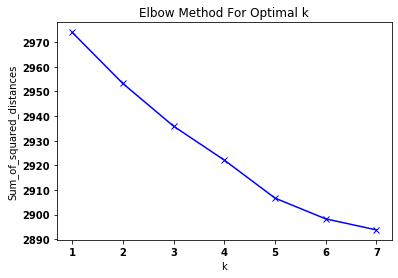

In [69]:

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [70]:

num_clusters = 7

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
centers = km.cluster_centers_
print(f"the cluster centers are {centers}")

joblib.dump(km,  'doc_cluster_best_K.pkl')

the cluster centers are [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.05613989e-04 3.89754959e-05 3.89754959e-05 ... 1.97185839e-05
  1.97185839e-05 1.97185839e-05]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


['doc_cluster_best_K.pkl']

In [71]:
km.cluster_centers_.argsort()

array([[    0, 54246, 54245, ...,  7785, 46541,  7583],
       [    0, 53292, 53291, ..., 76817, 44688, 53490],
       [11432, 46769, 46768, ..., 42552, 31519, 46541],
       ...,
       [    0, 54429, 54428, ..., 42717,  8400, 42552],
       [    0, 54379, 54378, ..., 46947, 33779, 33306],
       [    0, 54420, 54419, ..., 31589, 32228, 31519]], dtype=int64)

In [72]:
## Reversing the list so that index of max element is in 0th index
km.cluster_centers_.argsort()[:,::-1]

array([[ 7583, 46541,  7785, ..., 54245, 54246,     0],
       [53490, 44688, 76817, ..., 53291, 53292,     0],
       [46541, 31519, 42552, ..., 46768, 46769, 11432],
       ...,
       [42552,  8400, 42717, ..., 54428, 54429,     0],
       [33306, 33779, 46947, ..., 54378, 54379,     0],
       [31519, 32228, 31589, ..., 54419, 54420,     0]], dtype=int64)

In [73]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
for i in range(num_clusters):
    print("\n")
    print("Top words in Cluster-%d :" % i, end='')
    print("\n")
    for ind in order_centroids[i, :15]: #replace 6 with n words per cluster
        print('%s' % terms[ind].split(' '), end=',')

Top terms per cluster:


Top words in Cluster-0 :

['beautiful'],['love'],['beautiful', 'love'],['love', 'beautiful'],['scenery'],['beautiful', 'amazing'],['animal'],['amazing'],['beautiful', 'scenery'],['beautiful', 'cinematography'],['real'],['beautiful', 'classic'],['scenery', 'beautiful'],['cinematography'],['scene', 'beautiful'],

Top words in Cluster-1 :

['ok'],['little'],['unnecessary'],['remember'],['moment'],['like'],['completely', 'unnecessary'],['little', 'bit'],['bit'],['short'],['magical'],['completely'],['watch'],['line'],['well'],

Top words in Cluster-2 :

['love'],['good'],['like'],['amazing'],['enjoy'],['well'],['great'],['animal'],['watch'],['disney'],['awesome'],['real'],['animate'],['see'],['look'],

Top words in Cluster-3 :

['love'],['great', 'love'],['great'],['love', 'love'],['love', 'love', 'love'],['fanbase', 'huge', 'hate'],['fanbase'],['fanbase', 'doubt'],['fanbase', 'doubt', 'awful'],['fanbase', 'doubt', 'awful', 'okay'],['fanbase', 'huge'],['zoological',

In [74]:
!pip install num2words

In [75]:
!pip install emoji

# question to ask to chaitnya

1.if we observe class imbalance like more postitve than negative, are we supposed to to smote here. as it expected that a good movie 
will have more positive reviews than negative.
2. In that case when I tried to clustering, i got positive words in both the cluster. How to fix that. Are we not trying to have negative reviews in one cluster and
psotive reviews in another cluster.
#look at the elbow curve and decide on no of cluster to use. ideally it should look like all very good reviews in one cluster, medium good reviews in
#another cluster and neutral kind of reviews in another cluster and negative reviews in another cluster.
3. how to fix multiple different language in the text, using a translator is a very tedious job.
# ANs: while scrapping read only utf-8 reviews.
4. Is it a good idea to remove word which doesn't make sense as a single word but make sense as in bi gram or tri gram ?
#we are only interested in adjectives like amazinf, great, awesome.
#use number to text conversion package to convert number to text, that will help to build a good model.


#try to Use smote to learn how to use smote for text.
# use utf-8 while fetching data.
#learn how to convert emojji to text. https://pypi.org/project/emoji/
#num to word convertion .https://pypi.org/project/num2words/

# also find library to detect abbreviations in a text and replace.